In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pyedflib

import os
import sys
sys.path.append("..")

from sleeprnn.data import utils
from sleeprnn.common import viz, constants
from sleeprnn.helpers import reader

In [2]:
PATH_REC = 'register'
PATH_MARKS = os.path.join('label', 'spindle')
PATH_STATES = os.path.join('label', 'state')
KEY_FILE_EEG = 'file_eeg'
KEY_FILE_STATES = 'file_states'
KEY_FILE_MARKS = 'file_marks'
IDS_INVALID = [4, 8, 15, 16]
IDS_TEST = [2, 6, 12, 13]


class MassRaw(object):
    def __init__(self):
        self.fs = 256
        self.page_duration = 20
        self.page_size = int(self.page_duration * self.fs)
        self.channel = 'EEG C3-CLE'
        self.state_ids = np.array(['1', '2', '3', '4', 'R', 'W', '?'])
        self.unknown_id = '?'  # Character for unknown state in hypnogram
        self.n2_id = '2'  # Character for N2 identification in hypnogram
        valid_ids = [i for i in range(1, 20) if i not in IDS_INVALID]
        self.test_ids = IDS_TEST
        self.train_ids = [i for i in valid_ids if i not in self.test_ids]
        self.dataset_dir = os.path.abspath(os.path.join(utils.PATH_DATA, 'mass'))
        self.all_ids = self.train_ids + self.test_ids
        self.dataset_name = "mass_raw"
        
    def _get_file_paths(self):
        """Returns a list of dicts containing paths to load the database."""
        # Build list of paths
        data_paths = {}
        for subject_id in self.all_ids:
            path_eeg_file = os.path.join(
                self.dataset_dir, PATH_REC,
                '01-02-%04d PSG.edf' % subject_id)
            path_states_file = os.path.join(
                self.dataset_dir, PATH_STATES,
                '01-02-%04d Base.edf' % subject_id)
            path_marks_1_file = os.path.join(
                self.dataset_dir, PATH_MARKS,
                '01-02-%04d SpindleE1.edf' % subject_id)
            path_marks_2_file = os.path.join(
                self.dataset_dir, PATH_MARKS,
                '01-02-%04d SpindleE2.edf' % subject_id)
            # Save paths
            ind_dict = {
                KEY_FILE_EEG: path_eeg_file,
                KEY_FILE_STATES: path_states_file,
                '%s_1' % KEY_FILE_MARKS: path_marks_1_file,
                '%s_2' % KEY_FILE_MARKS: path_marks_2_file
            }
            # Check paths
            for key in ind_dict:
                if not os.path.isfile(ind_dict[key]):
                    print(
                        'File not found: %s' % ind_dict[key])
            data_paths[subject_id] = ind_dict
        return data_paths
    
    def get_subject_data(self, subject_id):
        data_paths = self._get_file_paths()
        path_dict = data_paths[subject_id]
        signal = self._read_eeg(path_dict[KEY_FILE_EEG])
        hypnogram, start_sample = self._read_states_raw(path_dict[KEY_FILE_STATES])
        signal, hypnogram, end_sample = self._fix_signal_and_states(signal, hypnogram, start_sample)
        return signal, hypnogram
    
    def _read_eeg(self, path_eeg_file):
        """Loads signal from 'path_eeg_file', does filtering and resampling."""
        with pyedflib.EdfReader(path_eeg_file) as file:
            channel_names = file.getSignalLabels()
            channel_to_extract = channel_names.index(self.channel)
            signal = file.readSignal(channel_to_extract)
            fs_old = file.samplefrequency(channel_to_extract)
        # Particular fix for mass dataset:
        fs_old_round = int(np.round(fs_old))
        # Transform the original fs frequency with decimals to rounded version
        signal = utils.resample_signal_linear(signal, fs_old=fs_old, fs_new=fs_old_round)
        signal = signal.astype(np.float32)
        return signal
    
    def _read_states_raw(self, path_states_file):
        """Loads hypnogram from 'path_states_file'."""
        with pyedflib.EdfReader(path_states_file) as file:
            annotations = file.readAnnotations()
        onsets = np.array(annotations[0])  # In seconds
        durations = np.round(np.array(annotations[1]))  # In seconds
        stages_str = annotations[2]
        # keep only 20s durations
        valid_idx = (durations == self.page_duration)
        onsets = onsets[valid_idx]
        stages_str = stages_str[valid_idx]
        stages_char = np.asarray([single_annot[-1] for single_annot in stages_str])
        # Sort by onset
        sorted_locs = np.argsort(onsets)
        onsets = onsets[sorted_locs]
        stages_char = stages_char[sorted_locs]
        # The hypnogram could start at a sample different from 0
        start_time = onsets[0]
        onsets_relative = onsets - start_time
        onsets_pages = np.round(onsets_relative / self.page_duration).astype(np.int32)
        n_scored_pages = 1 + onsets_pages[-1]  # might be greater than onsets_pages.size if some labels are missing
        start_sample = int(start_time * self.fs)
        hypnogram = (n_scored_pages + 1) * [self.unknown_id]  # if missing, it will be "?", we add one final '?'
        for scored_pos, scored_label in zip(onsets_pages, stages_char):
            hypnogram[scored_pos] = scored_label
        hypnogram = np.asarray(hypnogram)
        return hypnogram, start_sample

    def _fix_signal_and_states(self, signal, hypnogram, start_sample):
        # Crop start of signal
        signal = signal[start_sample:]
        # Find the largest valid sample, common in both signal and hypnogram, with an integer number of pages
        n_samples_from_signal = int(self.page_size * (signal.size // self.page_size))
        n_samples_from_hypnogram = int(hypnogram.size * self.page_size)
        n_samples_valid = min(n_samples_from_signal, n_samples_from_hypnogram)
        n_pages_valid = int(n_samples_valid / self.page_size)
        # Fix signal and hypnogram according to this maximum sample
        signal = signal[:n_samples_valid]
        hypnogram = hypnogram[:n_pages_valid]
        end_sample = start_sample + n_samples_valid  # wrt original beginning of recording, useful for marks
        return signal, hypnogram, end_sample

In [3]:
def get_spectrum(data, fs, f_min=0, f_max=40, window_fn=None):
    if window_fn is not None:
        window = window_fn(data.size)
        data = data * window
    y = np.fft.rfft(data)
    freq = np.fft.rfftfreq(data.size, d=1./fs)
    valid_locs = np.where((freq>=f_min) & (freq<=f_max))[0]
    freq = freq[valid_locs]
    y = y[valid_locs]
    return freq, y


def get_mean_spectrum(data, fs, f_min=0, f_max=40, window_fn=None):
    power_list = []
    for d in data:
        freq, y = get_spectrum(d, fs, f_min, f_max, window_fn)
        power_list.append(np.abs(y))
    power_mean = np.stack(power_list, axis=0).mean(axis=0)
    return freq, power_mean

# MASS-SS2-Train mean spectrum

In [4]:
mass = MassRaw()
fs = mass.fs
# Stages: ['1' '2' '3' '4' '?' 'R' 'W']

In [5]:
stages_for_spectrum = ['2']
powers = []
freq_axis = []
for subject_id in mass.train_ids:
    signal, hypnogram = mass.get_subject_data(subject_id)
    valid_locs = np.isin(hypnogram, stages_for_spectrum)
    signal = signal.reshape(-1, mass.page_size)
    signal = signal[valid_locs, :]
    freq, power_mean = get_mean_spectrum(signal, fs, f_min=1, f_max=40, window_fn=np.hanning)
    powers.append(power_mean)
    freq_axis.append(freq)
freq_axis = np.stack(freq_axis, axis=0).mean(axis=0)
powers = np.stack(powers, axis=0)
powers_n2 = powers

In [6]:
stages_for_spectrum = ['1', '2', '3', '4']
powers = []
freq_axis = []
for subject_id in mass.train_ids:
    signal, hypnogram = mass.get_subject_data(subject_id)
    valid_locs = np.isin(hypnogram, stages_for_spectrum)
    signal = signal.reshape(-1, mass.page_size)
    signal = signal[valid_locs, :]
    freq, power_mean = get_mean_spectrum(signal, fs, f_min=1, f_max=40, window_fn=np.hanning)
    powers.append(power_mean)
    freq_axis.append(freq)
freq_axis = np.stack(freq_axis, axis=0).mean(axis=0)
powers = np.stack(powers, axis=0)
powers_nrem = powers

In [7]:
def fit_power_law(f, p, f_min=0, f_max=40):
    # p = af^b -> log(p) = log(a) + b*log(f)
    valid_locs = np.where((f>=f_min) & (f<=f_max))[0]
    log_p = np.log(p[valid_locs])
    log_f = np.log(f[valid_locs])
    polycoefs = np.polynomial.Polynomial.fit(log_f, log_p, deg=1).convert().coef
    scale = polycoefs[0]
    exponent = polycoefs[1]
    return exponent, scale

def find_offset(freq_axis, power, offset_grid):
    error_list = []
    for offset in offset_grid:
        exponent, scale = fit_power_law(freq_axis + offset, power)
        power_fit = np.exp(scale) * ((freq_axis + offset) ** exponent)
        error = np.abs((power_fit - power)**2).mean()
        error_list.append(error)
    best = np.argmin(error_list)
    return offset_grid[best]

def find_offset_power_law(freq_axis, power):
    offset_grid = np.linspace(1, 10, 1000)
    offset = find_offset(freq_axis, power, offset_grid)
    exponent, scale = fit_power_law(freq_axis + offset, power)
    return scale, offset, exponent

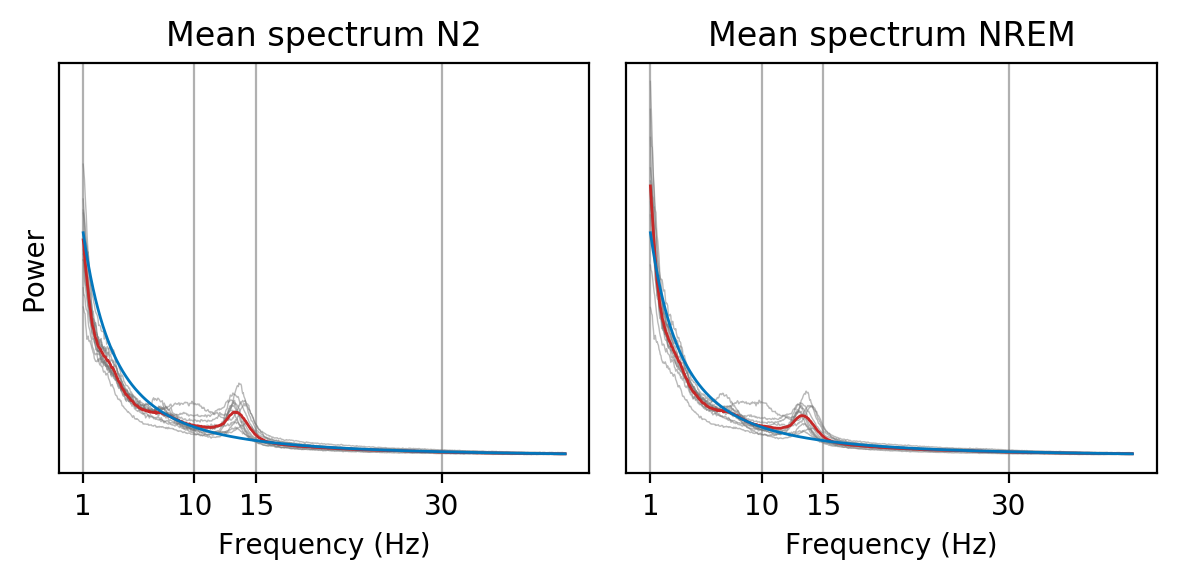

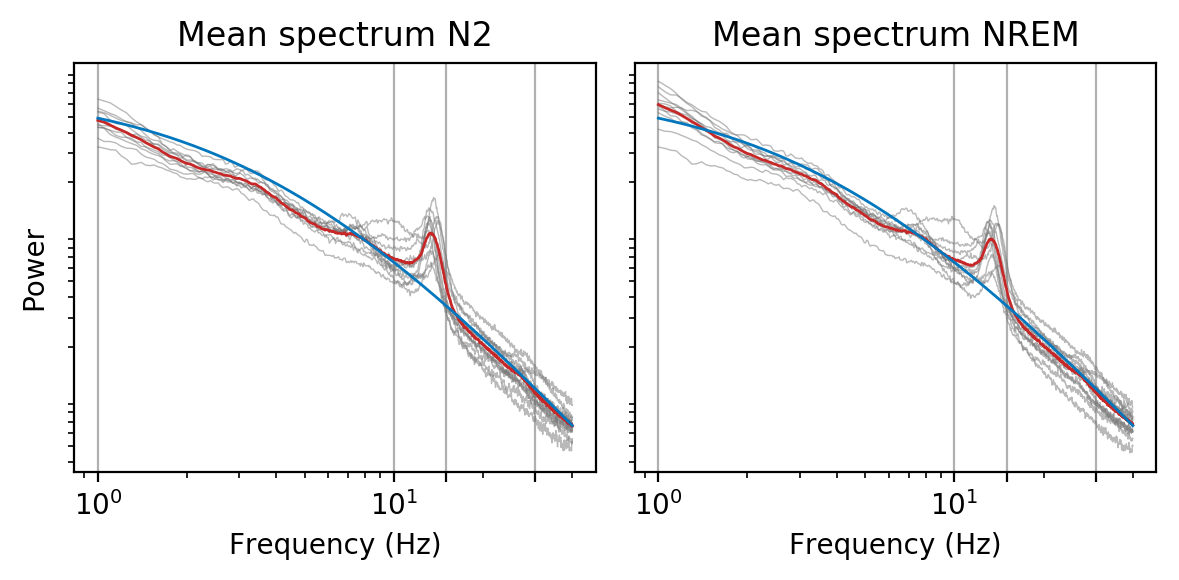

Power law fit
P = exp(A) * (f + B) ^ C with
A = 11.820769
B = 4.207207
C = -2.012350


In [8]:
# exponent_n2, scale_n2 = fit_power_law(freq_axis, powers_n2.mean(axis=0), f_min=1, f_max=15)
# exponent_nrem, scale_nrem = fit_power_law(freq_axis, powers_nrem.mean(axis=0), f_min=1, f_max=15)
# scale_n2, offset_n2, exponent_n2 = find_offset_power_law(freq_axis, powers_n2.mean(axis=0))
scale_nrem, offset_nrem, exponent_nrem = find_offset_power_law(freq_axis, powers_nrem.mean(axis=0))

fig, axes = plt.subplots(1, 2, figsize=(6, 3), dpi=200, sharex=True, sharey=True)
ax = axes[0]
ax.set_title("Mean spectrum N2")
for p in powers_n2:
    ax.plot(freq_axis, p, linewidth=0.5, color=viz.GREY_COLORS[6], alpha=0.5)
ax.plot(freq_axis, powers_n2.mean(axis=0), linewidth=1, color=viz.PALETTE['red'])
fitted_p = np.exp(scale_nrem) * ((freq_axis + offset_nrem) ** exponent_nrem)
ax.plot(freq_axis, fitted_p, linewidth=1, color=viz.PALETTE['blue'])
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("Power")
ax.set_xticks([1, 10, 15, 30])
ax.grid()
ax.set_yticks([])
ax = axes[1]
ax.set_title("Mean spectrum NREM")
for p in powers_nrem:
    ax.plot(freq_axis, p, linewidth=0.5, color=viz.GREY_COLORS[6], alpha=0.5)
ax.plot(freq_axis, powers_nrem.mean(axis=0), linewidth=1, color=viz.PALETTE['red'])
fitted_p = np.exp(scale_nrem) * ((freq_axis + offset_nrem) ** exponent_nrem)
ax.plot(freq_axis, fitted_p, linewidth=1, color=viz.PALETTE['blue'])
ax.set_xlabel("Frequency (Hz)")
ax.set_xticks([1, 10, 15, 30])
ax.grid()
ax.set_yticks([])
plt.tight_layout()
plt.show()


fig, axes = plt.subplots(1, 2, figsize=(6, 3), dpi=200, sharex=True, sharey=True)
ax = axes[0]
ax.set_title("Mean spectrum N2")
for p in powers_n2:
    ax.loglog(freq_axis, p, linewidth=0.5, color=viz.GREY_COLORS[6], alpha=0.5)
ax.loglog(freq_axis, powers_n2.mean(axis=0), linewidth=1, color=viz.PALETTE['red'])
fitted_p = np.exp(scale_nrem) * ((freq_axis + offset_nrem) ** exponent_nrem)
ax.loglog(freq_axis, fitted_p, linewidth=1, color=viz.PALETTE['blue'])
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("Power")
ax.set_xticks([1, 10, 15, 30])
ax.grid()
ax.set_yticks([])
ax = axes[1]
ax.set_title("Mean spectrum NREM")
for p in powers_nrem:
    ax.loglog(freq_axis, p, linewidth=0.5, color=viz.GREY_COLORS[6], alpha=0.5)
ax.loglog(freq_axis, powers_nrem.mean(axis=0), linewidth=1, color=viz.PALETTE['red'])
fitted_p = np.exp(scale_nrem) * ((freq_axis + offset_nrem) ** exponent_nrem)
ax.loglog(freq_axis, fitted_p, linewidth=1, color=viz.PALETTE['blue'])
ax.set_xlabel("Frequency (Hz)")
ax.set_xticks([1, 10, 15, 30])
ax.grid()
ax.set_yticks([])
plt.tight_layout()
plt.show()

print("Power law fit")
print("P = exp(A) * (f + B) ^ C with")
print("A = %1.6f" % scale_nrem)
print("B = %1.6f" % offset_nrem)
print("C = %1.6f" % exponent_nrem)

# PINK v2

In [ ]:
def generate_signal(
    n_seconds, fs, seed, std=16.7,
    padding_duration=10,
    offset=4.207207, 
    exponent=-2.012350, 
    f_low_clip=1,
):
    n_samples = int(n_seconds * fs)
    n_padding = int(padding_duration * fs)
    n_samples_expanded = n_samples + 2 * n_padding
    x = np.random.RandomState(seed=seed).normal(size=n_samples_expanded)
    y = np.fft.rfft(x)
    freq_gen = np.fft.rfftfreq(x.size, d=1./fs)
    freq_for_scaling = np.clip(freq_gen, a_min=f_low_clip, a_max=None)
    scaling = (freq_for_scaling + offset) ** exponent
    y = y * scaling
    x = np.fft.irfft(y)
    x = x[n_padding:-n_padding]
    x = x - x.mean()
    x = x / x.std()
    x = x * std
    return x